# Master overview
This master overview contains all graphs used in the final thesis, to make sure everything was trained and tested on the same data.

In [1]:
# utils
from util import evaluate_no_cv, calculate_auc_and_plot, get_epitope_df, get_features, fix_test, \
    evaluate_seperate_chains, get_columns_starting_with, get_counts, plot_scores

# distance measures
from util import ProximityForestClassifier

# distance functions
from util import calculate_tcr_dist2, calculate_tcr_dist2_cached, calculate_tcr_dist_multiple_chains, \
    calculate_tcr_dist, multi_dist, levenstein_distance, multi_lev, calculate_approx_distance, nan_hamming
from util import levenstein_distance
from util import calculate_approx_distance_or
from util import compose_all

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline

# own models
from CustomForest import RandomForest as CustomForest
from util import ProximityForestClassifier, KNNString

# other
import numpy as np
import pandas as pd
from datetime import datetime
import os

# models
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore",
                        category=UserWarning)  # hide: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [2]:
models_to_evaluate = []

In [3]:
# train/test data
folds = 5
epitope = "GILGFVFTL"
species = "HomoSapiens"
descr = "imputation-constant-numbers"

dataset_size = 50  # typically 50, 100, 200, 500, 1000, 2000, 5000 or None (None = all data)

data_per_fold = []
df_size = 0


def update_data_per_fold(dataset_size, epitope_=None):
    global data_per_fold, df_size, epitope, species, folds

    epitope = epitope_ if epitope_ is not None else epitope

    df = get_epitope_df(epitope, species=species)

    # for fixed test size (during the different size runs when sampling a few instances)
    df, test = train_test_split(df, test_size=0.2, random_state=0)
    test = test.sample(400, random_state=0)
    # test.dropna(inplace=True)
    # split test df into folds
    # test_folds = np.array_split(test, folds)
    # test = test.sample(100, random_state=0)

    df = df.sample(dataset_size, random_state=0) if dataset_size is not None else df
    df_size = len(df)

    data_per_fold = []
    for seed in range(folds):
        fold_data = {"seed": seed,
                     "epitope": epitope,
                     "species": species,
                     "df_size": df_size, }

        train_with_nan, test_with_nan = train_test_split(df, test_size=0.2, random_state=seed)

        # # for fixed test size (during the different size runs)
        # test_with_nan = test_folds[seed] # actually no nan, but no problem
        test_with_nan = test  # same test set for all folds

        test = test_with_nan.dropna()

        x_missing = train_with_nan.isna().any(axis=1)

        # with nan in train set
        x = get_features(train_with_nan)
        y = train_with_nan['reaction']

        # print the name of all columns in x that contain nan

        x_missing_test = test_with_nan.isna().any(axis=1)
        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        x_test_missing = x_test.isna().any(axis=1)

        y_test = test['reaction']

        alpha_only_count_pos, beta_only_count_pos, both_count_pos, non_count_pos = get_counts(train_with_nan)

        assert len(x) == len(x_missing) == len(y)
        assert len(x_test) == len(x_test_missing) == len(y_test)

        fold_data["nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'x_missing': x_missing,
                            'x_missing_test': x_missing_test, 'x_original': train_with_nan,
                            'x_test_original': test,
                            "train_alpha_only": alpha_only_count_pos, "train_beta_only": beta_only_count_pos,
                            "train_both": both_count_pos, "train_non": non_count_pos, 'train_total': len(x),
                            'test_total': len(x_test)}

        # without nan in train set
        train_without_nan = train_with_nan.dropna()
        x = get_features(train_without_nan)
        y = train_without_nan['reaction']

        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        y_test = test['reaction']

        assert len(x) == len(y)
        assert len(x_test) == len(y_test)

        fold_data["no_nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'train_total': len(x),
                               'test_total': len(x_test), 'train_both': len(train_without_nan), 'train_non': 0,
                               'x_original': train_without_nan, 'x_test_original': test,
                               'train_alpha_only': 0, 'train_beta_only': 0}

        data_per_fold.append(fold_data)

    # print train and test size for seed 0 (nan and no_nan)
    nan_data = data_per_fold[0]["nan"]
    no_nan_data = data_per_fold[0]["no_nan"]
    print(f"Nan: train: {len(nan_data['x'])}, test: {len(nan_data['x_test'])}")
    print(f"No Nan: train: {len(no_nan_data['x'])}, test: {len(no_nan_data['x_test'])}")

In [4]:
def evaluate_model(model_description):
    """
    model description is a dict with the following keys:
    - name*: name of the model
    - model*: the model
    - imputer: the imputer to use
    - chain: 'both', 'alpha', 'beta' or 'seperate'. In cas of 'seperate', model_alpha and model_beta must be defined instead of model
    - drop_train_na: if True, all rows with nan in the train set are dropped
    - missing_indicator: if True, a missing indicator is added as feature
    - columns_to_use: list of columns to use (CDR, V, J)
    - extract_features: if False, the original columns are used and no features are extracted
    """
    global data_per_fold

    assert "name" in model_description
    assert "model" in model_description

    scores = pd.DataFrame()

    num_folds = len(data_per_fold)
    for i in range(num_folds):

        model_train_nan = not model_description.get("drop_train_na", False)
        data_name = "nan" if model_train_nan else "no_nan"

        chain = model_description.get("chain", "both")
        assert chain in ["both", "alpha", "beta", "seperate"]

        # get the precomputed dataset for this fold (either the version with nan or without nan
        fold_data = data_per_fold[i]
        fold_dataset = fold_data[data_name]
        x = fold_dataset["x"].copy()
        y = fold_dataset["y"].copy()
        x_test = fold_dataset["x_test"].copy()
        y_test = fold_dataset["y_test"].copy()

        columns_to_use = model_description.get("columns_to_use", None)

        extract_features = model_description.get("extract_features", True)

        # set the columns_to_use if only specific gene features are used
        gene_features = model_description.get("gene_features", None)
        if gene_features is not None:
            assert gene_features in ["FV", "F", "V", "F+V", "FV+F+V"]  #, "CDR_only"]

            column_map = {'F': ['V_family', 'J_family'],
                          'V': ['V_version', 'J_version'],
                          'FV': ['V', 'J']}
            column_map['F+V'] = column_map['F'] + column_map['V']
            column_map['FV+F+V'] = column_map['FV'] + column_map['F'] + column_map['V']
            # add CDR3 to all
            for key in column_map:
                column_map[key].append('CDR3')

            columns_to_use = column_map[gene_features]

        # if there needs to be other columns or no features need to be extracted, the pre-computed features won't work
        if columns_to_use is not None or not extract_features:
            if columns_to_use is None:
                columns_to_use = ["CDR3", "V", "J"]

            # recreate train data
            x_original = fold_dataset["x_original"]
            x_test_original = fold_dataset["x_test_original"]

            x = get_features(x_original, columns=columns_to_use, extract_features=extract_features)

            x_test = get_features(x_test_original, columns=columns_to_use, test=True, extract_features=extract_features)
            x_test = fix_test(x_test, x.columns)
            x_test.dropna(inplace=True)

        # add missing indicator if needed
        missing_indicator = model_description.get("missing_indicator", False)
        if missing_indicator:
            x_missing = fold_dataset["x_missing"]
            x_missing_test = fold_dataset["x_missing_test"]
            x["missing"] = x_missing
            x_test["missing"] = x_missing_test

        # get only alpha or beta chain if needed
        if chain == "alpha" or chain == "beta":
            x = get_columns_starting_with(x, f'{chain}_')
            x_test = get_columns_starting_with(x_test, f'{chain}_')

        model_imputer = model_description.get("imputer", None)

        separate_chains = chain == "seperate"

        try:
            if separate_chains:
                model_alpha = model_description["model_alpha"]
                model_beta = model_description["model_beta"]
                auc = evaluate_seperate_chains(model_alpha, model_beta, x, y, x_test, y_test, model_imputer)
            else:
                model = model_description["model"]
                if model_imputer is not None:
                    model = Pipeline([('imputer', model_imputer), ('model', model)])
                    model_imputer = None
                auc = evaluate_no_cv(model, x, y, x_test, y_test, model_imputer)

            # add the scores to the dataframe
            index = len(scores)
            scores.loc[index, 'model'] = model_description['name']
            scores.loc[index, 'auc'] = auc
            scores.loc[index, 'model_train_nan'] = model_train_nan
            scores.loc[index, 'imputer'] = model_imputer.__class__.__name__ if model_imputer is not None else None
            scores.loc[index, 'chain'] = chain
            scores.loc[index, 'group'] = model_description['group']

            scores.loc[index, 'seed'] = fold_data["seed"]
            scores.loc[index, 'epitope'] = fold_data["epitope"]
            scores.loc[index, 'species'] = fold_data["species"]

            scores.loc[index, 'train_alpha_only'] = fold_dataset["train_alpha_only"]
            scores.loc[index, 'train_beta_only'] = fold_dataset["train_beta_only"]
            scores.loc[index, 'train_both'] = fold_dataset["train_both"]
            scores.loc[index, 'train_non'] = fold_dataset["train_non"]
            scores.loc[index, 'train_total'] = fold_dataset["train_total"]
            scores.loc[index, 'test_total'] = fold_dataset["test_total"]
            scores.loc[index, 'df_size'] = fold_data["df_size"]

            scores.loc[index, 'gene_features'] = gene_features
            scores.loc[index, 'missing_indicator'] = missing_indicator

            # print the row
            # print(scores.loc[index])
            # print(f"AUC(m={model_description['name']}, s={seed}, train_na={int(model_train_nan)}): {auc}")
            print(auc)

        except Exception as e:
            print(f"Error: {e}")
            raise e  # for debugging
            continue

    return scores

In [5]:
def evaluate_model_list(models_to_evaluate):
    assert len(models_to_evaluate) > 0, "No models to evaluate"

    start_time = datetime.now()
    timestamp = start_time.strftime("%Y%m%d-%H%M%S")
    # create a directory in outputs to save the files to
    global epitope, df_size, descr
    output_dir = f"outputs/model-evaluations-{timestamp}-{epitope}-{df_size}-{descr}"
    os.makedirs(output_dir, exist_ok=True)

    output_log = f"{output_dir}/log.txt"
    with open(output_log, 'w') as f:
        f.write(f"Started at {start_time}\n\n")
        f.write(f"Models to evaluate: {len(models_to_evaluate)}\n\n")
        for i, model in enumerate(models_to_evaluate):
            f.write(f"{i + 1}/{len(models_to_evaluate)}: {model['name']}\n")
            f.write(f"{model}\n\n")

    scores = pd.DataFrame()
    for i, model in enumerate(models_to_evaluate):
        print(f"\nEvaluating model {i + 1}/{len(models_to_evaluate)}")
        print(model)
        model_scores = evaluate_model(model)

        model_scores['test_nr'] = i + 1
        model_scores.to_csv(f"{output_dir}/{i + 1}-{model['name']}.csv")

        scores = pd.concat([scores, model_scores])
    # write to csv
    end_time = datetime.now()

    time_taken = end_time - start_time
    timestamp = end_time.strftime("%Y%m%d-%H%M%S")
    scores.to_csv(f"{output_dir}/scores-{timestamp}.csv")

    plot_scores(scores, "All models", output_file=f"{output_dir}/all-models.png", hue_group_diff=False)

    # create a directory 'groups'
    groups_dir = f"{output_dir}/groups"
    os.makedirs(groups_dir, exist_ok=True)
    # for each group in the scores, save a csv with the scores for that group
    for group in scores['group'].unique():
        group_scores = scores[scores['group'] == group]

        # always add the baseline group
        if group != 'baseline':
            baseline_scores = scores[scores['group'] == 'baseline']
            group_scores = pd.concat([baseline_scores, group_scores])

        group_scores.to_csv(f"{groups_dir}/{group}.csv")
        plot_scores(group_scores, group, output_file=f"{groups_dir}/{group}.png", hue_group_diff=False)

    print(f'Finished evaluating {len(models_to_evaluate)} models at {timestamp} in {time_taken} seconds')

    with open(output_log, 'a') as f:
        f.write(f"Finished at {end_time}\n")
        f.write(f"Time taken: {time_taken}\n")
        f.write(f"Saved scores to {output_dir}\n")
        f.write(f"Saved all scores to {output_dir}/scores-{timestamp}.csv\n")
        f.write(f"Saved group scores to {groups_dir}\n")
        f.write(f"Saved all group scores to {groups_dir}/all-models.png\n")
        f.write(f"Saved all models to {output_dir}/all-models.png\n")
        f.write(f"Saved log to {output_log}\n")

    return scores, f"{output_dir}/scores-{timestamp}.csv"

In [6]:
# imputers
zero_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
most_freq_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [7]:
% % script echo skipping

# baseline (random forest, nans dropped in train)
baseline = {
    'name': 'Random Forest (NaNs dropped in train)',
    'model': RandomForestClassifier(random_state=0),
    'drop_train_na': True,
    'group': 'baseline',
}
models_to_evaluate.append(baseline)

Couldn't find program: 'echo'


In [8]:
% % script echo skipping

# random forest imputations
rf_zero_imputed = {
    'name': 'Random Forest (Zero imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': zero_imputer,
    'group': 'rf_imputations'
}

rf_mean_imputed = {
    'name': 'Random Forest (Mean imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'rf_imputations'
}

rf_most_freq_imputed = {
    'name': 'Random Forest (Most frequent imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': most_freq_imputer,
    'group': 'rf_imputations'
}

rf_median_imputed = {
    'name': 'Random Forest (Median imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': median_imputer,
    'group': 'rf_imputations'
}

rf_imputation_models = [rf_zero_imputed, rf_mean_imputed, rf_most_freq_imputed, rf_median_imputed]
models_to_evaluate.extend(rf_imputation_models)

Couldn't find program: 'echo'


In [9]:
% % script echo skipping

rf_impute_0 = {
    'name': 'Random Forest (0 imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': zero_imputer,
    'group': 'rf_imputations'
}

rf_impute_10 = {
    'name': 'Random Forest (10 imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=10),
    'group': 'rf_imputations'
}

rf_impute_100 = {
    'name': 'Random Forest (100 imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=100),
    'group': 'rf_imputations'
}

models_to_evaluate.extend([rf_impute_0, rf_impute_10, rf_impute_100])

Couldn't find program: 'echo'


In [10]:
% % script echo skipping

# knn imputers
rf_knn_imputed_1 = {
    'name': 'Random Forest (KNN imputed, k=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=1),
    'group': 'rf_knn_imputations'
}

rf_knn_imputed_5 = {
    'name': 'Random Forest (KNN imputed, k=5)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=5),
    'group': 'rf_knn_imputations'
}

rf_knn_imputed_15 = {
    'name': 'Random Forest (KNN imputed, k=10)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=10),
    'group': 'rf_knn_imputations'
}

rf_knn_imputation_models = [rf_knn_imputed_1, rf_knn_imputed_5, rf_knn_imputed_15]
models_to_evaluate.extend(rf_knn_imputation_models)

Couldn't find program: 'echo'


In [11]:
% % script echo skipping

# iterative imputations
rf_iterative_imputed_1 = {
    'name': 'Random Forest (Iterative imputed, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_5 = {
    'name': 'Random Forest (Iterative imputed, max_iter=5)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=5),
    'group': 'rf_iterative_imputations'
}

# rf_iterative_imputed_10 = {
#     'name': 'Random Forest (Iterative imputed, max_iter=10)',
#     'model': RandomForestClassifier(random_state=0),
#     'imputer': impute.IterativeImputer(max_iter=10),
#     'group': 'rf_iterative_imputations'
# }
#
# rf_iterative_imputed_15 = {
#     'name': 'Random Forest (Iterative imputed, max_iter=15)',
#     'model': RandomForestClassifier(random_state=0),
#     'imputer': impute.IterativeImputer(max_iter=15),
#     'group': 'rf_iterative_imputations'
# }

# rf_iterative_imputation_models = [rf_iterative_imputed_1, rf_iterative_imputed_5, rf_iterative_imputed_10, rf_iterative_imputed_15]
rf_iterative_imputation_models = [rf_iterative_imputed_1, rf_iterative_imputed_5]
models_to_evaluate.extend(rf_iterative_imputation_models)

Couldn't find program: 'echo'


In [12]:
% % script echo skipping

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# iterative imputer with RandomForestRegressor, KNeighborsRegressor and MLP
# max_iter=1

rf_iterative_imputed_rfr = {
    'name': 'RF (Iterative imputed, RandomForestRegressor, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1, estimator=RandomForestRegressor(random_state=0)),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_knr = {
    'name': 'RF (Iterative imputed, KNeighborsRegressor, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1, estimator=KNeighborsRegressor()),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_mlp = {
    'name': 'RF (Iterative imputed, MLPRegressor, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1, estimator=MLPRegressor(random_state=0)),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputation_models = [rf_iterative_imputed_rfr, rf_iterative_imputed_knr, rf_iterative_imputed_mlp]
models_to_evaluate.extend(rf_iterative_imputation_models)

Couldn't find program: 'echo'


In [13]:
% % script echo skipping

# knn classifier
knn_classifier_mean_imputed = {
    'name': 'KNN Classifier (mean imputed)',
    'model': KNeighborsClassifier(),
    'group': 'knn',
    'imputer': mean_imputer
}

knn_classifier_knn_imputed = {
    'name': 'KNN Classifier (KNN imputed)',
    'model': KNeighborsClassifier(),
    'group': 'knn',
    'imputer': impute.KNNImputer()
}

knn_models = [knn_classifier_mean_imputed, knn_classifier_knn_imputed]
models_to_evaluate.extend(knn_models)

Couldn't find program: 'echo'


In [14]:
% % script echo skipping

# missing indicator imputations
# same models as above, but with missing indicator
rf_imputation_models_with_missing_indicator = []
for model in rf_imputation_models:
    model_with_missing_indicator = model.copy()
    model_with_missing_indicator['name'] += " (with missing indicator)"
    model_with_missing_indicator['missing_indicator'] = True
    model_with_missing_indicator['group'] = 'rf_imputations_with_missing_indicator'
    rf_imputation_models_with_missing_indicator.append(model_with_missing_indicator)

models_to_evaluate.extend(rf_imputation_models_with_missing_indicator)

Couldn't find program: 'echo'


In [15]:
% % script echo skipping

# gradient boosting classifiers
hist_gradient_boosting = {
    'name': 'HistGradientBoosting',
    'model': HistGradientBoostingClassifier(random_state=0),
    'group': 'gradient_boosting'
}

xgboost = {
    'name': 'XGBoost',
    'model': XGBClassifier(random_state=0),
    'group': 'gradient_boosting'
}

lightgbm = {
    'name': 'LightGBM',
    'model': LGBMClassifier(random_state=0),
    'group': 'gradient_boosting'
}

gradient_boosting_models = [hist_gradient_boosting, xgboost, lightgbm]
models_to_evaluate.extend(gradient_boosting_models)

Couldn't find program: 'echo'


In [16]:
% % script echo skipping

# gene features
features_to_test = ["FV", "F", "V", "F+V", "FV+F+V"]
gene_feature_models = []
for features in features_to_test:
    model = {
        'name': f"Random Forest ({features})",
        'model': RandomForestClassifier(random_state=0),
        'gene_features': features,
        'group': 'gene_features',
        'imputer': mean_imputer,
    }
    gene_feature_models.append(model)

models_to_evaluate.extend(gene_feature_models)

Couldn't find program: 'echo'


In [17]:
% % script echo skipping

# chain inputs
both_chains = {
    'name': 'Random Forest (both chains)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'both',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

alpha_chain = {
    'name': 'Random Forest (Alpha chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'alpha',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

beta_chain = {
    'name': 'Random Forest (Beta chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'beta',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

seperate_chains = {
    'name': 'Random Forest (Seperate chains)',
    'model_alpha': RandomForestClassifier(random_state=0),
    'model_beta': RandomForestClassifier(random_state=0),
    'chain': 'seperate',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

chain_input_models = [both_chains, alpha_chain, beta_chain, seperate_chains]
models_to_evaluate.extend(chain_input_models)

Couldn't find program: 'echo'


In [18]:
% % script echo skipping

chain_input_without_nans = []
for model in chain_input_models:
    model_without_nans = model.copy()
    model_without_nans['name'] += " (without nans)"
    model_without_nans['drop_train_na'] = True
    model_without_nans['imputer'] = None
    chain_input_without_nans.append(model_without_nans)
models_to_evaluate.extend(chain_input_without_nans)

Couldn't find program: 'echo'


In [19]:
% % script echo skipping

# WeightedRandomForest
weighted_random_forest = {
    'name': 'RandomForest (own impl., weighted)',
    'model': CustomForest(weighted=True),  # doesn't support random state
    'group': 'weighted_random_forest',
}

custom_random_forest = {
    'name': 'RandomForest (own impl.)',
    'model': CustomForest(weighted=False),
    'group': 'weighted_random_forest',
    'imputer': mean_imputer,
}

# # to check whether it's the same as non-weighted, which is indeed the case
# weighted_random_forest_no_nan = {
#     'name': 'RandomForest (own impl., weighted, no nan)',
#     'model': CustomForest(weighted=True), # doesn't support random state
#     'group': 'weighted_random_forest',
#     'drop_train_na': True,
# }

custom_random_forest_no_nan = {
    'name': 'RandomForest (own impl., no nan)',
    'model': CustomForest(weighted=False),
    'group': 'weighted_random_forest',
    'drop_train_na': True,
}

weighted_random_forest_models = [weighted_random_forest, custom_random_forest, weighted_random_forest_no_nan,
                                 custom_random_forest_no_nan]
models_to_evaluate.extend(weighted_random_forest_models)

Couldn't find program: 'echo'


In [20]:
% % script echo skipping

# rf_cdr_only = {
#     'name': 'RandomForest (only CDR3)',
#     'model': RandomForestClassifier(random_state=0),
#     'group': 'cdr_only',
#     'columns_to_use': ['CDR3'],
#     'imputer': mean_imputer,
# }

rf_cdr_only_no_nan = {
    'name': 'RandomForest (only CDR3, no_nan)',
    'model': RandomForestClassifier(random_state=0),
    'group': 'cdr_only',
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

models_to_evaluate.extend([rf_cdr_only_no_nan])

Couldn't find program: 'echo'


In [21]:
% % script echo skipping

# knn classifier with different distance measures
# knn classifier
knn_tcr_dist_no_nan = {
    'name': 'KNN (tcr_dist, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=calculate_tcr_dist_multiple_chains),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_lev_dist_no_nan = {
    'name': 'KNN (lev, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=multi_lev),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_hamming_dist_no_nan = {
    'name': 'KNN (hamming, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=nan_hamming),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_tcrdist3_no_nan = {
    'name': 'KNN (tcrdist3, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=calculate_tcr_dist2_cached),
    'group': 'knn_metrics',
    'extract_features': False,
    'drop_train_na': True,
}

models_to_evaluate.extend([knn_tcr_dist_no_nan, knn_lev_dist_no_nan, knn_hamming_dist_no_nan, knn_tcrdist3_no_nan])

Couldn't find program: 'echo'


In [22]:
% % script echo skipping

proximity_forest_no_nan = {
    'name': 'ProximityForest (nan_dist=0, measure=tcr_dist)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

proximity_forest_models = [proximity_forest_no_nan]

models_to_evaluate.extend(proximity_forest_models)

Couldn't find program: 'echo'


In [23]:
% % script echo skipping

# More ProximityForest
# proximity_forest_nan_150 = {
#     'name': 'ProximityForest (nan_dist=150, measure=tcr_dist)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains,
#                                       distance_kwargs={"nan_distance": 150}),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3'],
# }


# proximity_forest_tcr_dist2 = {
#     'name': 'ProximityForest (nan_dist=0, measure=tcr_dist2)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }
#
# proximity_forest_no_nan_tcr_dist2 = {
#     'name': 'ProximityForest (no_nan, measure=tcr_dist2)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

# proximity_forest_tcr_dist2_approx = {
#     'name': 'ProximityForest (nan_dist, measure=tcr_approx)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance, distance_kwargs={'nan_distance': 0}),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }

# proximity_forest_no_nan_tcr_dist2_approx = {
#     'name': 'ProximityForest (no_nan, measure=tcr_approx)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

# proximity_forest_lev = {
#     'name': 'ProximityForest (nan_dist=0, measure=lev)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=multi_lev),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }
#
# proximity_forest_no_nan_lev = {
#     'name': 'ProximityForest (no_nan, measure=lev)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=multi_lev),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

proximity_forest_hamm = {
    'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=nan_hamming),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': False,
}

proximity_forest_no_nan_hamm = {
    'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=nan_hamming),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

# models_to_evaluate.append(proximity_forest_nan_150)
# models_to_evaluate.append(proximity_forest_tcr_dist2)
# models_to_evaluate.append(proximity_forest_no_nan_tcr_dist2)
# models_to_evaluate.append(proximity_forest_tcr_dist2_approx)
# models_to_evaluate.append(proximity_forest_no_nan_tcr_dist2_approx)
# models_to_evaluate.append(proximity_forest_lev)
# models_to_evaluate.append(proximity_forest_no_nan_lev)
models_to_evaluate.append(proximity_forest_hamm)
models_to_evaluate.append(proximity_forest_no_nan_hamm)

Couldn't find program: 'echo'


In [24]:
% % script echo skipping

from sklearn.neural_network import MLPClassifier

# %%script echo skipping
# mean imputation on a random forest, KNN classifier, proximity forest, MLP, histgradientboosting

impute_rf = {
    'name': 'RandomForest (mean imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

impute_knn = {
    'name': 'KNN (mean imputed)',
    'model': KNeighborsClassifier(),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

impute_proximity_forest = {
    'name': 'ProximityForest (mean imputed)',
    'model': ProximityForestClassifier(),
    'imputer': mean_imputer,
    'group': 'mean_impute_models',
}

impute_mlp = {
    'name': 'MLP (mean imputed)',
    'model': MLPClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

impute_hist_gradient_boosting = {
    'name': 'HistGradientBoosting (mean imputed)',
    'model': HistGradientBoostingClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

mean_imputed_classification_models = [
    impute_rf,
    impute_knn,
    impute_proximity_forest,
    impute_mlp,
    impute_hist_gradient_boosting,
]


In [29]:
% % script echo skipping

# take all mean_imputed classification models, without nans

mean_imputed_classification_models_no_nan = []
for model in mean_imputed_classification_models:
    new_model = model.copy()
    new_model['name'] = new_model['name'].replace("mean imputed", "no nan")
    new_model['drop_train_na'] = True
    # remove imputer from the dict
    del new_model['imputer']
    mean_imputed_classification_models_no_nan.append(new_model)

models_to_evaluate.extend(mean_imputed_classification_models_no_nan)

In [30]:
print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)
    # plot_scores(scores, "Model performance (AUC)", baseline_name='RandomForest (0, inputed)', hue_group_diff=False)


['RandomForest (no nan)', 'KNN (no nan)', 'ProximityForest (no nan)', 'MLP (no nan)', 'HistGradientBoosting (no nan)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8567241379310344
0.815862068965517
0.8737931034482759
0.8539655172413793
0.8617241379310344

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.6513793103448275
0.4889655172413794
0.6613793103448277
0.4889655172413794
0.6413793103448275

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_impu

Predicting: 100%|██████████| 100/100 [00:01<00:00, 79.59it/s]


0.7770689655172415


Predicting: 100%|██████████| 100/100 [00:01<00:00, 96.69it/s]


0.6768965517241379


Predicting: 100%|██████████| 100/100 [00:00<00:00, 122.25it/s]


0.7839655172413792


Predicting: 100%|██████████| 100/100 [00:01<00:00, 93.27it/s]


0.7577586206896552


Predicting: 100%|██████████| 100/100 [00:01<00:00, 70.80it/s]


0.7760344827586206

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7396551724137931
0.598448275862069
0.586551724137931
0.47913793103448277
0.6770689655172414

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.5
0.5
0.5
0.5
0.5
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-165929 in 0:00:10.419774 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv']
### Dataset size: 100 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.9058620689655171
0.8698275862068966
0.8901724137931034
0.8629310344827587
0.8877586206896553

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7736206896551723
0.796206896551724
0.703448275862069
0.703103448275862
0.7170689655172414

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_imput

Predicting: 100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


0.7486206896551725


Predicting: 100%|██████████| 100/100 [00:01<00:00, 60.78it/s]


0.7601724137931034


Predicting: 100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


0.7239655172413793


Predicting: 100%|██████████| 100/100 [00:02<00:00, 43.72it/s]


0.7096551724137932


Predicting: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


0.716551724137931

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7993103448275862
0.8024137931034482
0.6548275862068966
0.8020689655172415
0.6003448275862069

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.5
0.5
0.5
0.5
0.5
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170002 in 0:00:19.659293 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbers/scores-20230614-170002.csv']
### Dataset size: 200 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.9098275862068965
0.895
0.8920689655172414
0.8670689655172412
0.8844827586206897

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8122413793103447
0.8362068965517241
0.8267241379310345
0.8196551724137933
0.8322413793103447

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_impute_models'

Predicting: 100%|██████████| 100/100 [00:04<00:00, 21.24it/s]


0.7762068965517241


Predicting: 100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


0.8512068965517241


Predicting: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


0.7836206896551724


Predicting: 100%|██████████| 100/100 [00:02<00:00, 36.42it/s]


0.7998275862068965


Predicting: 100%|██████████| 100/100 [00:03<00:00, 31.88it/s]


0.8518965517241379

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8210344827586207
0.7993103448275862
0.7855172413793103
0.8148275862068965
0.7589655172413793

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8760344827586207
0.7955172413793105
0.8510344827586207
0.5
0.5
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170101 in 0:00:40.231059 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbers/scores-20230614-170002.c

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8832758620689654
0.8863793103448276
0.890344827586207
0.8832758620689655
0.8756896551724137

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8103448275862069
0.8005172413793102
0.8287931034482758
0.8210344827586207
0.8410344827586206

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_i

Predicting: 100%|██████████| 100/100 [00:03<00:00, 32.58it/s]


0.8572413793103448


Predicting: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


0.8524137931034482


Predicting: 100%|██████████| 100/100 [00:03<00:00, 30.44it/s]


0.856551724137931


Predicting: 100%|██████████| 100/100 [00:03<00:00, 33.12it/s]


0.8510344827586206


Predicting: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


0.8622413793103448

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7779310344827585
0.7758620689655172
0.8220689655172414
0.8162068965517242
0.8196551724137932

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8751724137931034
0.9086206896551724
0.8851724137931035
0.8948275862068965
0.9113793103448276
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170218 in 0:01:05.050767 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-nu

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.891551724137931
0.8837931034482758
0.8979310344827586
0.8932758620689655
0.8758620689655172

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8368965517241379
0.8468965517241378
0.838448275862069
0.8501724137931035
0.8610344827586206

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_im

Predicting: 100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


0.8784482758620689


Predicting: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


0.8612068965517242


Predicting: 100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


0.8684482758620689


Predicting: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


0.863448275862069


Predicting: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


0.8708620689655173

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8603448275862068
0.8772413793103448
0.859655172413793
0.8637931034482759
0.823103448275862

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8958620689655172
0.887241379310345
0.9010344827586205
0.8910344827586207
0.8796551724137929
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170418 in 0:01:40.989767 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbe

<Figure size 432x288 with 0 Axes>

In [10]:
models_to_evaluate = []

In [14]:
# distance functions
# knn with tcrdist3

knn_tcrdist3 = {
    'name': 'KNN (tcrdist3, no_nan)',
    'model': KNNString(metric=calculate_tcr_dist2_cached, k=5),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': True,
}

# tcrdist values (from random observations) 0-400
# typically 200-300

knn_tcrdist3_nan_250 = {
    'name': 'KNN (tcrdist3, nan_dist=200)',
    'model': KNNString(metric=calculate_tcr_dist2_cached, k=5, metric_kwargs={'nan_distance': 250}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

models_to_evaluate.append(knn_tcrdist3)
models_to_evaluate.append(knn_tcrdist3_nan_250)

In [15]:
print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50]  # takes too long for larger datasets
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

['KNN (tcrdist3, no_nan)', 'KNN (tcrdist3, no_nan)', 'KNN (tcrdist3, nan_dist=0)', 'KNN (tcrdist3, nan_dist=100)', 'KNN (tcrdist3, nan_dist=200)', 'KNN (tcrdist3, nan_dist=400)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/6
{'name': 'KNN (tcrdist3, no_nan)', 'model': <util.knnstring.KNNString object at 0x000001F8B7E177F0>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8051724137931033
0.7525862068965516


KeyboardInterrupt: 

In [7]:
models_to_evaluate = []

# knn with tcrdist approx
knn_tcrdist_approx = {
    'name': 'KNN (tcrdist approx, no_nan)',
    'model': KNNString(metric=calculate_approx_distance, k=5),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': True,
}

knn_tcrdist_approx_nan_0 = {
    'name': 'KNN (tcrdist approx, nan_dist=0)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 0}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

knn_tcrdist_approx_nan_100 = {
    'name': 'KNN (tcrdist approx, nan_dist=100)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 100}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

knn_tcrdist_approx_nan_250 = {
    'name': 'KNN (tcrdist approx, nan_dist=200)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 250}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

knn_tcrdist_approx_nan_400 = {
    'name': 'KNN (tcrdist approx, nan_dist=400)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 400}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

# 0.7 and 0.7 is too low

models_to_evaluate.append(knn_tcrdist_approx)
models_to_evaluate.append(knn_tcrdist_approx_nan_0)
models_to_evaluate.append(knn_tcrdist_approx_nan_100)
models_to_evaluate.append(knn_tcrdist_approx_nan_250)
models_to_evaluate.append(knn_tcrdist_approx_nan_400)

In [8]:
print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50]  # takes too long for larger datasets
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

['KNN (tcrdist approx, no_nan)', 'KNN (tcrdist approx, nan_dist=0)', 'KNN (tcrdist approx, nan_dist=100)', 'KNN (tcrdist approx, nan_dist=200)', 'KNN (tcrdist approx, nan_dist=400)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'KNN (tcrdist approx, no_nan)', 'model': <util.knnstring.KNNString object at 0x00000250728FE1F0>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8051724137931034
0.7165517241379311
0.8455172413793104
0.7948275862068965
0.8015517241379311

Evaluating model 2/5
{'name': 'KNN (tcrdist approx, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x00000250728FE1C0>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.5
0.5
0.5
0.3951724137931034
0.5

Evaluating model 3/5
{'name': 'KNN (tcrdist approx, nan_dist=100)', 'model': <util.knnstring.KNNString object at 0x0000025

<Figure size 432x288 with 0 Axes>

['KNN (levenstein, no_nan)', 'KNN (levenstein, nan_dist=0)', 'KNN (levenstein, nan_dist=2)', 'KNN (levenstein, nan_dist=7)', 'KNN (levenstein, nan_dist=12)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D580>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.7931034482758621
0.5325862068965517
0.7941379310344828
0.6424137931034481
0.7591379310344827

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D700>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.7227586206896551
0.809655172413793
0.8367241379310346
0.8393103448275863
0.6974137931034481

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model': 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D580>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8675862068965519
0.8232758620689654
0.8172413793103449
0.756896551724138
0.8027586206896552

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D700>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.913448275862069
0.9027586206896552
0.9124137931034483
0.9324137931034482
0.9291379310344827

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model': 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D580>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9125862068965517
0.8977586206896552
0.9012068965517241
0.8956896551724137
0.9065517241379311

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D700>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9172413793103449
0.8991379310344828
0.9206896551724139
0.9077586206896552
0.9298275862068965

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D580>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9127586206896552
0.9191379310344827
0.9241379310344826
0.9149999999999999
0.9391379310344826

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D700>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.8863793103448276
0.9187931034482759
0.924655172413793
0.9163793103448276
0.896896551724138

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model'

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D580>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9079310344827586
0.906896551724138
0.9010344827586206
0.9070689655172414
0.8913793103448275

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000014DF615D700>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9074137931034483
0.9424137931034482
0.9070689655172414
0.8843103448275862
0.8958620689655172

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model

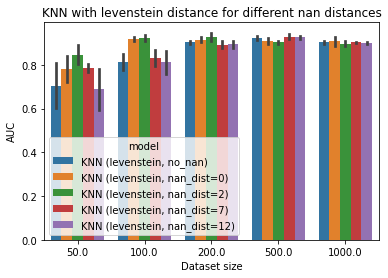

Baseline Random Forest (NaNs dropped in train) not found in scores, using KNN (levenstein, no_nan) instead


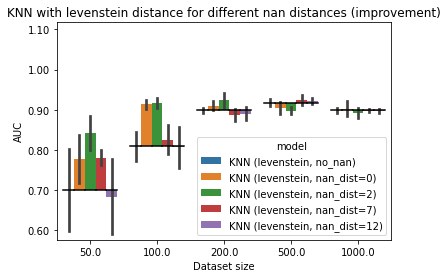

In [8]:
# levenstein distance (typically 0-14)

models_to_evaluate = [

    {'name': 'KNN (levenstein, no_nan)',
     'model': KNNString(metric=multi_lev, k=5),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': True},

    {'name': 'KNN (levenstein, nan_dist=0)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 0}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'KNN (levenstein, nan_dist=2)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 2}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'KNN (levenstein, nan_dist=7)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 7}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'KNN (levenstein, nan_dist=12)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 12}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},
]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "KNN with levenshtein distance for different nan distances"
output = "graphs/GILGFVFTL-knn-lev-nan-distances.png"
composed_df = compose_all(outputs, 'knn_lev')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

In [ ]:
# proximity forest, levenstein distance

models_to_evaluate = [

    {'name': 'ProximityForest (levenstein, no_nan)',
     'model': KNNString(metric=multi_lev, k=5),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': True},

    {'name': 'ProximityForest (levenstein, nan_dist=7)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 7}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "ProximityForest with levenshtein distance for different nan distances"
output = "graphs/GILGFVFTL-knn-lev-nan-distances.png"
composed_df = compose_all(outputs, 'knn_lev')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

In [ ]:
# proximity forest, different candidate_splits

models_to_evaluate = [

    {'name': 'ProximityForest (sqrt, lev, nd=7)',
     'model': ProximityForestClassifier(distance_measure=multi_lev, sample_multiple_splits='sqrt',
                                        distance_kwargs={'nan_distance': 7}),
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'ProximityForest (half, lev, nd=7)',
     'model': ProximityForestClassifier(distance_measure=multi_lev, sample_multiple_splits='half',
                                        distance_kwargs={'nan_distance': 7}),
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'ProximityForest (all, lev, nd=7)',
     'model': ProximityForestClassifier(distance_measure=multi_lev, sample_multiple_splits='all',
                                        distance_kwargs={'nan_distance': 7}),
     'extract_features': False,
     'drop_train_na': False},

]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "ProximityForest with different number of candidate splits"
output = "graphs/GILGFVFTL-pf-candidate-splits.png"
composed_df = compose_all(outputs, 'pf_candidate_splits')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

### Epitope: GILGFVFTL ###
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/2
{'name': 'RandomForest (No NaNs)', 'model': RandomForestClassifier(random_state=0), 'group': 'different_epitopes', 'drop_train_na': True}
0.8567241379310344
0.815862068965517
0.8737931034482759
0.8539655172413793
0.8617241379310344

Evaluating model 2/2
{'name': 'RandomForest (Mean imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(), 'group': 'different_epitopes', 'drop_train_na': False}
0.8825862068965518
0.8725862068965516
0.8877586206896552
0.8886206896551724
0.8879310344827587
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (No NaNs) instead


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/2
{'name': 'RandomForest (No NaNs)', 'model': RandomForestClassifier(random_state=0), 'group': 'different_epitopes', 'drop_train_na': True}
0.9058620689655171
0.8698275862068966
0.8901724137931034
0.8629310344827587
0.8877586206896553

Evaluating model 2/2
{'name': 'RandomForest (Mean imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(), 'group': 'different_epitopes', 'drop_train_na': False}
0.9162068965517242
0.8962068965517241
0.9089655172413793
0.8896551724137931
0.8958620689655172
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (No NaNs) instea

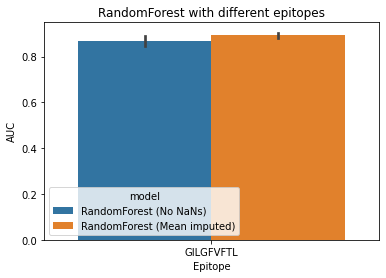

Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (No NaNs) instead


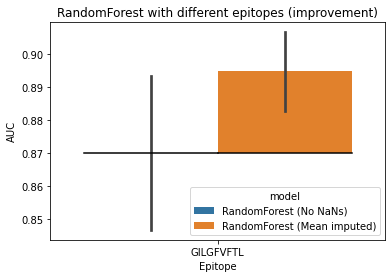

In [11]:
epitopes = ['GILGFVFTL']

models_to_evaluate = [

    {'name': 'RandomForest (No NaNs)',
     'model': RandomForestClassifier(random_state=0),
     'group': 'different_epitopes',
     'drop_train_na': True},

    {'name': 'RandomForest (Mean imputed)',
     'model': RandomForestClassifier(random_state=0),
     'imputer': mean_imputer,
      'group': 'different_epitopes',
     'drop_train_na': False, }
]

df_sizes = [50, 100]
outputs = []
for epitope in epitopes:
    print(f"### Epitope: {epitope} ###")
    for df_size in df_sizes:
        print(f"### Dataset size: {df_size} ###")
        update_data_per_fold(df_size, epitope_=epitope)
        scores, output_csv = evaluate_model_list(models_to_evaluate)
        outputs.append(output_csv)
        print(outputs)
    print(f"Finished {epitope}")
    print(outputs)

title = "RandomForest with different epitopes"
output = "graphs/GILGFVFTL-rf-different-epitopes.png"
composed_df = compose_all(outputs, 'rf_different_epitopes')
plot_scores(composed_df, title, wrap=True, x="epitope", hue="model", xlabel="Epitope", ylabel="AUC",
            output_file=output,
            plot=True)
